In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle

%matplotlib inline
np.random.seed(1)

### 1. Getting Data from the file
    Read the CIFAR data file. This has 5 train batches of size 10K each and one test batch of size 10k.
    Each image is 32*32*3 == 3072
    So each batch has dimension of 10,000*3072

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
train_data = [{},{},{},{},{},{}] 
for i in range(1,6):
    train_data[i] = unpickle("/Users/dibu/Gatech Academics/BigDataSystems-CS6220/Assignments/A1/workspace/cifar-10-batches-py/data_batch_"+str(i))

In [4]:
test_data=unpickle("/Users/dibu/Gatech Academics/BigDataSystems-CS6220/Assignments/A1/workspace/cifar-10-batches-py/test_batch")

In [5]:
for x in train_data[1]:
  print(x)
print(train_data[i][b'data'].shape)

b'batch_label'
b'labels'
b'data'
b'filenames'
(10000, 3072)


In [6]:
def load_dataset():
    x=[]
    y=[]
    for i in range(1,6):
        x.append(train_data[i][b'data'])
        y.append(train_data[i][b'labels'])
    
    xtr = np.concatenate(x).reshape(50000,3,32,32).transpose(0,2,3,1)
    ytr = np.concatenate(y)
    xte = test_data[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1)
    yte = np.array(test_data[b'labels'])
    
    min_image =  np.min(xtr, axis=0)
    max_image = np.max(xtr, axis = 0)
    xtr = (xtr - min_image) / (max_image-min_image)
    xte = (xte - min_image) / (max_image-min_image)
    
    
    return xtr,ytr,xte,yte,np.arange(9)

In [7]:
def convert_to_onehot(X, num_classes):
    
    num_classes = tf.constant(num_classes, name="num_classes")
    one_hot_matrix = tf.one_hot(X, depth= num_classes, axis= 1)
    session = tf.Session()
    X_one_hot = session.run(one_hot_matrix)
    session.close()
    return X_one_hot

In [8]:
X_train, Y_train, X_test, Y_test, classes = load_dataset()
Y_train = convert_to_onehot(Y_train,10);
Y_test = convert_to_onehot(Y_test,10);

In [9]:
print("X_train shape: "+ str(X_train.shape))
print("Y_train shape: "+ str(Y_train.shape))
print("X_test shape: "+ str(X_test.shape))
print("Y_test shape: "+ str(Y_test.shape))

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


### 2- Sample Data   
    (Train Data: Test Data) == (80:20)

In [10]:
sample = np.random.randint(low=0, high=50000, size=10000)
X_train_sample = X_train[sample]
Y_train_sample = Y_train[sample]


sample = np.random.randint(low=0, high=10000, size=2000)
X_test_sample = X_test[sample]
Y_test_sample = Y_test[sample]

print("X_train Sample shape: "+ str(X_train_sample.shape))
print("Y_train Sample shape: "+ str(Y_train_sample.shape))
print("X_test Sample shape: "+ str(X_test_sample.shape))
print("Y_test Sample shape: "+ str(Y_test_sample.shape))


X_train Sample shape: (10000, 32, 32, 3)
Y_train Sample shape: (10000, 10)
X_test Sample shape: (2000, 32, 32, 3)
Y_test Sample shape: (2000, 10)


### 3 -  Tensorflow Forward Pass


In [11]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

### 4 - Initialize Filters

In [12]:
def initialize_parameters():
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### 5- Forward Propagation

In [19]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    #Conv2d
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    print(Z1.shape)
    # RELU
    A1 = tf.nn.relu(Z1)
    print(A1.shape)
    # MAXPOOL
    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    print(P1.shape)
    # CONV2D
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    print(Z2.shape)
    # RELU
    A2 = tf.nn.relu(Z2)
    print(A2.shape)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides= [1,4,4,1], padding='SAME')
    # FLATTEN
    print(P2.shape)
    P2 = tf.contrib.layers.flatten(P2)
    print(P2.shape)
    # FULLY-CONNECTED 
    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn=None)
    print(Z3.shape)

    return Z3

### 6 - Compute Cost

In [14]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

### 7 - Build Model

In [15]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [17]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 100, minibatch_size = 200, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape    
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(?, 32, 32, 8)
(?, 32, 32, 8)
(?, 8, 8, 8)
(?, 8, 8, 16)
(?, 8, 8, 16)
(?, 2, 2, 16)
Instructions for updating:
Use keras.layers.flatten instead.
(?, 64)
(?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 2.174098
Cost after epoch 5: 1.583532
Cost after epoch 10: 1.463865
Cost after epoch 15: 1.401956
Cost after epoch 20: 1.378458
Cost after epoch 25: 1.360480
Cost after epoch 30: 1.327599
Cost after epoch 35: 1.310673
Cost after epoch 40: 1.288057
Cost after epoc

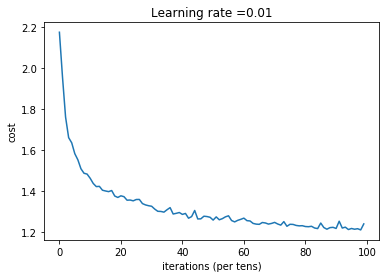

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.5719
Test Accuracy: 0.5035


In [18]:
_, _, parameters = model(X_train_sample, Y_train_sample, X_test_sample, Y_test_sample)

###Outlier Test